## In this file we will train the Finetune TrOCR-Base-Printed. We will first do text detection with Pytesseract then the output of those will be given to the model for training

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (6,050 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

## Applying image segmentation using pytessearact on the train images so that the words are detected. Then pairing the text-detected images with thir respective transcripts

In [ ]:
import cv2
import pytesseract
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define paths
input_dir = "/content/drive/MyDrive/human_ai_folder/processed_images"
output_dir = "/content/drive/MyDrive/human_ai_folder/detecting_words"
os.makedirs(output_dir, exist_ok=True)

# Get all image files
image_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')]

# Iterate through images
for img_path in tqdm(image_files):
    # Read image
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Morphological operations to enhance text regions
    kernel = np.ones((2, 2), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    morph = cv2.dilate(morph, kernel, iterations=1)

    # Use Tesseract for word-level detection
    data = pytesseract.image_to_data(morph, output_type=pytesseract.Output.DICT)

    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 30:  # Filter low-confidence words
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Save output image with bounding boxes
    output_path = os.path.join(output_dir, os.path.basename(img_path))
    cv2.imwrite(output_path, image)

100%|██████████| 14/14 [02:02<00:00,  8.74s/it]


In [ ]:
import os
import re
from glob import glob

# Define paths
img_dir = "/content/drive/MyDrive/human_ai_folder/detecting_words"
txt_dir = "/content/drive/MyDrive/human_ai_folder/transcripts"

# Manual mapping for inconsistent names
name_correction = {
    "Constituciones": "Constituciones sinodales"
}

# Get all image file paths
image_files = sorted(glob(os.path.join(img_dir, "*.jpg")))

# Function to extract document name and page number from image filename
def extract_doc_and_page(image_filename):
    match = re.match(r"(.*)-page_(\d+)", image_filename)
    if match:
        doc_name, page_num = match.groups()

        # Correct document name if needed
        doc_name = name_correction.get(doc_name, doc_name)

        return doc_name, f"page{page_num}.txt"
    return None, None

# Create mapping between images and transcripts
image_text_pairs = []
for img_path in image_files:
    img_name = os.path.basename(img_path).replace(".jpg", "")
    doc_name, page_filename = extract_doc_and_page(img_name)

    if doc_name and page_filename:
        transcript_folder = os.path.join(txt_dir, f"transcript_{doc_name}")
        text_path = os.path.join(transcript_folder, page_filename)

        if os.path.exists(text_path):
            image_text_pairs.append((img_path, text_path))

# Check dataset size
print(f"Found {len(image_text_pairs)} image-text pairs")

# Display a few samples
for i, (img, txt) in enumerate(image_text_pairs[:5]):  # Show only 5 samples
    print(f"Sample {i+1}:")
    print(f"  Image Path    : {img}")
    print(f"  Transcript Path: {txt}")
    print("-" * 50)

Found 14 image-text pairs
Sample 1:
  Image Path    : /content/drive/MyDrive/human_ai_folder/detecting_words/Buendia-page_1.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page1.txt
--------------------------------------------------
Sample 2:
  Image Path    : /content/drive/MyDrive/human_ai_folder/detecting_words/Buendia-page_2.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page2.txt
--------------------------------------------------
Sample 3:
  Image Path    : /content/drive/MyDrive/human_ai_folder/detecting_words/Buendia-page_3.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page3.txt
--------------------------------------------------
Sample 4:
  Image Path    : /content/drive/MyDrive/human_ai_folder/detecting_words/Constituciones-page_1.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Constituciones sinodales/pag

## Augmenting the images with a little bit of noise and rotation for generalising the data

In [ ]:
import albumentations as A
import cv2
import numpy as np
from tqdm import tqdm

# Define augmentation pipeline
augmentations = A.Compose([
    A.Rotate(limit=3, p=0.5),  # Slight rotation
    A.RandomBrightnessContrast(p=0.5),  # Adjust brightness & contrast
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),  # Inject noise
    A.MotionBlur(blur_limit=3, p=0.3),  # Simulate motion blur
])

# Define output directory for augmented images
augmented_data_dir = "/content/drive/MyDrive/human_ai_folder/augmented_images"
os.makedirs(augmented_data_dir, exist_ok=True)

num_augmentations = 10  # Generate 10 augmented versions per image
augmented_pairs = []

# Loop through original image-text pairs
for img_path, text_path in tqdm(image_text_pairs):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Save the original image (unchanged) in augmented dataset
    img_name = os.path.basename(img_path)
    orig_img_path = os.path.join(augmented_data_dir, img_name)
    cv2.imwrite(orig_img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    augmented_pairs.append((orig_img_path, text_path))

    # Generate multiple augmented images per original
    for i in range(1, num_augmentations + 1):
        augmented_img = augmentations(image=img)["image"]
        aug_img_name = img_name.replace(".jpg", f"_aug{i}.jpg")

        aug_img_path = os.path.join(augmented_data_dir, aug_img_name)
        cv2.imwrite(aug_img_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))

        # Store mapping (augmented image -> original transcript)
        augmented_pairs.append((aug_img_path, text_path))

# Check dataset size
print(f"Total augmented dataset size: {len(augmented_pairs)} images")

<ipython-input-5-985981d802fa>:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),  # Inject noise
100%|██████████| 14/14 [02:00<00:00,  8.61s/it]

Total augmented dataset size: 154 images


In [ ]:

for i, (img, txt) in enumerate(augmented_pairs[:5]):
    print(f"Augmented Sample {i+1}:")
    print(f"  Image Path    : {img}")
    print(f"  Transcript Path: {txt}")
    print("-" * 50)

Augmented Sample 1:
  Image Path    : /content/drive/MyDrive/human_ai_folder/augmented_images/Buendia-page_1.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page1.txt
--------------------------------------------------
Augmented Sample 2:
  Image Path    : /content/drive/MyDrive/human_ai_folder/augmented_images/Buendia-page_1_aug1.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page1.txt
--------------------------------------------------
Augmented Sample 3:
  Image Path    : /content/drive/MyDrive/human_ai_folder/augmented_images/Buendia-page_1_aug2.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page1.txt
--------------------------------------------------
Augmented Sample 4:
  Image Path    : /content/drive/MyDrive/human_ai_folder/augmented_images/Buendia-page_1_aug3.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Bu

In [ ]:
!pip install transformers torch torchvision Pillow datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Making the OCRdataset and importing the TrOCR baseline model to be finetuned

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from torch.nn.utils.rnn import pad_sequence
import torch

class OCRDataset(Dataset):
    def __init__(self, image_text_pairs, processor,max_length=512):
        self.image_text_pairs = image_text_pairs
        self.processor = processor
        self.max_length=max_length

    def normalize_text(self, text):
        """Apply historical OCR normalization rules"""
        text = text.replace("ſ", "s")  # Long 's' → 's'
        text = text.replace("ç", "z")  # ç → z
        text = text.replace("q̄", "que")  # q-macron → que
        text = text.replace("u", "v") if "v" in text else text.replace("v", "u")  # u ↔ v
        text = text.translate(str.maketrans("áéíóú", "aeiou"))  # Remove accents (except ñ)
        return text



    def __len__(self):
        return len(self.image_text_pairs)


    def __getitem__(self, idx):
        img_path, text_path = self.image_text_pairs[idx]

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Load text
        with open(text_path, "r", encoding="utf-8") as f:
            text = f.read().strip()

        text = self.normalize_text(text)


        # Process image and text
        encoding = self.processor(
            image,
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
            )

        return {
            "pixel_values": encoding["pixel_values"].squeeze(0),  # Image tensor
            "labels": encoding["labels"].squeeze(0),        # Tokenized text
            }



def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])

    labels = pad_sequence([item['labels'] for item in batch], batch_first=True, padding_value=-100)
    return {'pixel_values': pixel_values, 'labels': labels}

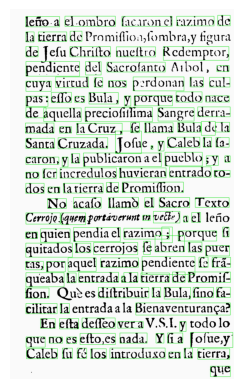

Extracted Text:
leño  a el ombro sacaron el razimo de
la tierra de Promission, sombra, y figura
de Jesu Christo nuestro Redemptor, 
pendiente del Sacrosanto Arbol, en
cuya virtud se nos perdonan las cul-
pas: esso es Bula, y porque todo nace
de aquella preciosissima Sangre derra-
mada en la Cruz, se llama Bula de la
Santa Cruzada. Josue, y Caleb la sa-
caron, y la publicaron a el pueblo; y a 
no ser incredulos huvieran entrado to-
dos en la tierra de Promission. 
No acaso llamó el Sacro Texto
Cerrojo (quem portaverunt in vecte) a el leño
en quien pendia el razimo; porque si
quitados los cerrojos se abren las puer
tas, por aquel razimo pendiente se fran-
queaba la entrada a la tierra de Promis-
sion. Que es distribuir la bula, sino fa-
cilitar la entrada a la Bienaventuranza?
En esta desseo ver a V.S.I. y todo lo 
que no es esto, es nada. Y si a Josue, y 
Caleb su fe los introduxo en la tierra,


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Select a random image-text pair
img_path, txt_path = random.choice(augmented_pairs)

# Display the image
img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")
plt.show()

# Read and print corresponding text
with open(txt_path, "r", encoding="utf-8") as f:
    text = f.read()
print(f"Extracted Text:\n{text}")

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Load the processor and model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

# Ensure model is on GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(device)
# Check model structure
print(model)

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.50.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

cpu
VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
          

In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into train and validation sets (80% train, 20% validation)
train_pairs, val_pairs = train_test_split(augmented_pairs, test_size=0.2, random_state=42)

# Create dataset objects
train_dataset = OCRDataset(train_pairs, processor)
val_dataset = OCRDataset(val_pairs, processor)

# Print dataset sizes
print(f"Training Set Size: {len(train_dataset)}")
print(f"Validation Set Size: {len(val_dataset)}")

Training Set Size: 123
Validation Set Size: 31


In [ ]:
def postprocess_ocr_output(text):
    text = text.replace("ſ", "s")  # Long 's' → 's'
    text = text.replace("ç", "z")  # ç → z
    text = text.replace("q̄", "que")  # q-macron → que
    text = text.translate(str.maketrans("áéíóú", "aeiou"))  # Remove accents (except ñ)
    return text

In [ ]:
import torch
import torch.nn as nn
from transformers import Trainer

class CustomTrainer(Trainer):
    def __init__(self, processor,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ctc_loss = nn.CTCLoss(blank=processor.tokenizer.pad_token_id, zero_infinity=True)
        self.processor=processor

    def compute_loss(self, model, inputs,num_items_in_batch=None, return_outputs=False):
        pixel_values = inputs["pixel_values"]
        labels = inputs["labels"]

        # Forward pass
        outputs = model(pixel_values, labels=labels)
        logits = outputs.logits  # Model predictions        loss = outputs.loss  # Default loss

        # Computed the CTC loss manually
        input_lengths = torch.full(
            (logits.shape[0],), logits.shape[1], dtype=torch.long
        )  # Assume full sequence length
        target_lengths = (labels != -100).sum(dim=-1)  # Counting of non-padding tokens

        # Replace -100 with pad_token_id before computing loss
        labels = torch.where(labels == -100, processor.tokenizer.pad_token_id, labels)

        loss = self.ctc_loss(
            logits.permute(1, 0, 2).log_softmax(2),  # (seq_len, batch, vocab_size)
            labels,
            input_lengths,
            target_lengths
        )

        pred_texts = self.processor.batch_decode(logits.argmax(dim=-1), skip_special_tokens=True)
        gt_texts = self.processor.batch_decode(labels, skip_special_tokens=True)

        pred_texts = [postprocess_ocr_output(txt) for txt in pred_texts]  # Apply postprocessing
        gt_texts = [postprocess_ocr_output(txt) for txt in gt_texts]

        return (loss, outputs) if return_outputs else loss

In [ ]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/human_ai_folder/ocr_model",
    per_device_train_batch_size=4,  # Reduce if still OOM
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,  # Accumulate gradients to simulate larger batch size
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=4,
    num_train_epochs=15,
    logging_dir="/content/drive/MyDrive/human_ai_folder/log",
    logging_steps=50,
    logging_strategy="steps",
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_steps=500,
    lr_scheduler_type="linear",
    load_best_model_at_end=True,
    fp16=True,
    push_to_hub=False
)




trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor.tokenizer,
    data_collator=collate_fn,
    processor=processor
     # Pass custom loss function
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-13-06190ead5948>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [ ]:
from accelerate import Accelerator

# Reset and reinitialize the accelerator
accelerator = Accelerator()
accelerator.state._reset_state()
accelerator = Accelerator()  # Reinitialize

# Ensure Trainer is using the new accelerator
trainer.accelerator = accelerator

In [ ]:
trainer.train()

## sample testing for model evaluation

In [ ]:
image_path = "/content/drive/MyDrive/human_ai_folder/testing_folder/Mendo-page_4.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)

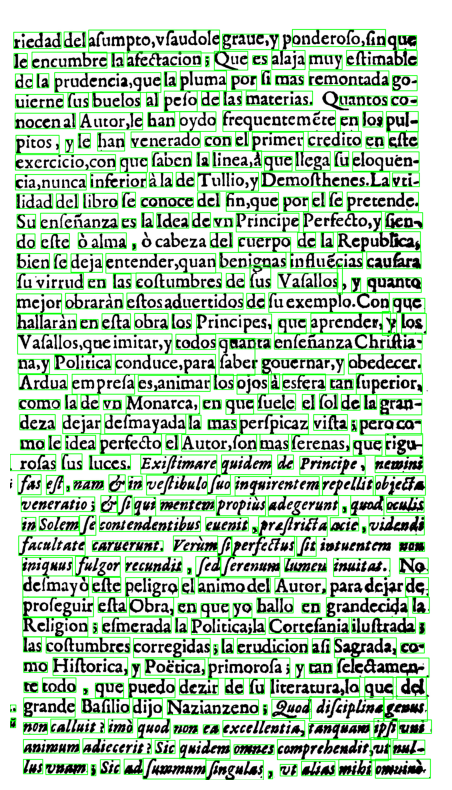

In [ ]:
for i in range(len(data['text'])):
    if int(data['conf'][i]) > 0:  # Ignore low-confidence detections
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
from PIL import Image
import torch

# Specify the path to the latest/best checkpoint
checkpoint_path = "/content/drive/MyDrive/human_ai_folder/ocr_model/checkpoint-124"  # Change this to the latest checkpoint

# Load the fine-tuned model
model = VisionEncoderDecoderModel.from_pretrained(checkpoint_path)
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")

# Ensure model is in evaluation mode
model.eval()



Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.50.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

In [ ]:
# Function to perform OCR on an image
def process_text_regions(image, data):
    extracted_text = ""

    for i in range(len(data['text'])):
        text = data['text'][i].strip()
        if text:
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            cropped_region = image[y:y+h, x:x+w]
            pil_img = Image.fromarray(cropped_region).convert("RGB")

            # Process with TrOCR
            pixel_values = processor(pil_img, return_tensors="pt").pixel_values
            generated_ids = model.generate(pixel_values)
            decoded_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            extracted_text += decoded_text + " "

    return extracted_text

# Extract and recognize text
final_text = process_text_regions(gray, data)
print("Extracted Text:")
print(final_text)

Extracted Text:
RIEDAD DEL AFUMPTO,VIAUDOLE GRAUE,Y ONDEROFO,FIN UC IE ENCUMBRE LA AFETACION : QUE CS ALAJA MILY ETHIMABLE DC LA PRUDENCIA, QUE LA PLUMA POR 0 MAS REMONTADA GO- UICTHE CUS BUELOS AL PEFO DE LAS MATERIAS. UANTOS CO- NOCCEN AL AUTOR,LE BAN OYPO FACEQUENTEMERE EN 109 PUL- DITOS, Y LE BAN VENERADO CON EL PRIMER CREDITO CN CFTE EXERCICIO,CON GUE TABLEN 1 LINEA,A QUE ILEGA FU ELOGUEN- CIA,NUMCA INFERIOR ALA DE TULIO,Y DEMOTHENES.LA VILI- LIDAD DEL LIBRO TE CONOCE DEL KN,QUE POR EL TE PRETENCE. SU ENTERNZA CS LA IDEA DE VIN PRINCIPE PERFETO, Y GEN- OD EFFE O ALMA > 0- CABEZA DEL CUERPO DE LA REPUBLICAS BIEN TE DEJA ENTENDER,QUAN BENIGNAS INFUECIAS CAUFARA FU'VIRUD CN LAS COFTUMBERS DE BUS VARALLOS 1 Y QUANTQ MEJOR OBRARAN EFTOSADUERTIDOS DE FU EXEMPLO.COM QUE. BALLARAN EN ERTA OBRA LOS PRINCIPES, QUE APRENDER, Y 2 LOS. VAFALLOS,QUEIMITARY TODOS MADTA ENTERNZA CHRIFILA - NA,Y POLITICA CONDUCE,PARA 656 SOUERNAR, Y OBEDECER. ARDUA EMPREFA ES,AMIMAR LOS OJOS A- ESFERA TAN SUPERIOR

In [ ]:
    def normalize_text(text):
        """Apply historical OCR normalization rules"""
        text = text.replace("ſ", "s")  # Long 's' → 's'
        text = text.replace("ç", "z")  # ç → z
        text = text.replace("q̄", "que")  # q-macron → que
        text = text.replace("u", "v") if "v" in text else text.replace("v", "u")  # u ↔ v
        text = text.translate(str.maketrans("áéíóú", "aeiou"))  # Remove accents (except ñ)
        return text

In [ ]:
transcript_path = "/content/drive/MyDrive/human_ai_folder/testing_folder/page4.txt"
with open(transcript_path, "r", encoding="utf-8") as f:
    ground_truth_text = f.read().strip()


ground_truth_text=normalize_text(ground_truth_text)

In [ ]:
print("\nGround Truth Transcript:\n", ground_truth_text)


Ground Truth Transcript:
 eriedad del asvmpto, vsavdole grave, y ponderoso, sin qve
le encvmbre la afectacion; Qve es alaja mvy estimable
de la prvdencia, qve la plvma por si mas remontada qo-
vierne svs bvelos al peso de las materias. Qvantos co-
nocen al Avtor, le han oydo freqventemente en los pvl-
pitos, y le han venerado con el primer credito en este
exercicio, con qve saben la linea, a qve llega sv eloqven-
cia, nvnca inferior a la de Tvllio, y Demosthenes. La vti-
lidad del libre se conoce del fin, qve por el se pretende.
Sv enseñanza es la Idea de vn Principe Perfecto, y siend-
do este o alma, o cabeza del cverpo de la Repvblica,
bien se deja entender, qvan benignas inflvencias cavsara
sv virtvd en las costvmbres de svs Vasallos, y qvanto
mejor obraran estos advertidos de sv exemplo. Con qve
hallaran en esta obra los Principes, qve aprender, y los
Vasallos, qve imitar, y todos qvanta enseñanza Christia-
na, y Politica condvce, para saber governar, y obedecer.
Ardva empresa es,

In [ ]:
!pip install spacy
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 81.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import re
import spacy

# Load Spanish NLP model for sentence and proper noun detection
nlp = spacy.load("es_core_news_sm")

def correct_case(text):
    # Convert everything to lowercase
    text = text.lower()

    # Process text using spaCy for sentence detection
    doc = nlp(text)

    # Capitalize the first letter of each sentence
    corrected_text = " ".join(
        [sent.text.capitalize() for sent in doc.sents]
    )

    return corrected_text

# Example usage
extracted_text = final_text  # Your OCR output
clean_text = correct_case(extracted_text)
print(clean_text)


Riedad del afumpto,viaudole graue,y onderofo,fin uc ie encumbre la afetacion : que cs alaja mily ethimable dc la prudencia, que la pluma por 0 mas remontada go- uicthe cus buelos al pefo de las materias. Uantos co- noccen al autor,le ban oypo facequentemere en 109 pul- ditos, y le ban venerado con el primer credito cn cfte exercicio,con gue tablen 1 linea,a que ilega fu eloguen- cia,numca inferior ala de tulio,y demothenes.la vili- lidad del libro te conoce del kn,que por el te pretence. Su enternza cs la idea de vin principe perfeto, y gen- od effe o alma > 0- cabeza del cuerpo de la republicas bien te deja entender,quan benignas infuecias caufara fu'virud cn las coftumbers de bus varallos 1 y quantq mejor obraran eftosaduertidos de fu exemplo.com que. Ballaran en erta obra los principes, que aprender, y 2 los. Vafallos,queimitary todos madta enternza chrifila - na,y politica conduce,para 656 souernar, y obedecer. Ardua emprefa es,amimar los ojos a- esfera tan superior, como la de vd 

In [ ]:
!pip install Levenshtein jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.6 MB/s eta 0:00:00


In [ ]:
import pytesseract
import cv2
import Levenshtein
from jiwer import wer

In [ ]:
cer = Levenshtein.distance(clean_text, ground_truth_text) / max(len(ground_truth_text), 1)
wer_value = wer(ground_truth_text, clean_text)
print(f"\nCER (Character Error Rate): {cer:.4f}")
print(f"WER (Word Error Rate): {wer_value:.4f}")


CER (Character Error Rate): 0.2595
WER (Word Error Rate): 0.8924
